In [ ]:
#Luis Maldonado-Rosado


!pip install scikit-surprise

import pandas as pd
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic, SVD
from surprise import accuracy

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505182 sha256=d7ed553f03b3535c00f0ce559121b8cd91b493ded9a421867d6a5987876f7286
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


###Problem 1

In [ ]:

df = pd.read_csv("problem1.csv")

# Drop the "Unnamed: 0" column
if "Unnamed: 0" in df.columns:
    df.drop("Unnamed: 0", axis=1, inplace=True)

print(df.head())

# Create the Surprise dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["id", "item", "rating"]], reader)


   id     item  rating
0   0   Q114_2       1
1   0     Q137       1
2   0     Q129       4
3   0  Q116__1       4
4   1      Q35       1


In [ ]:

# Split data into training and testing 80/20

trainset, testset = train_test_split(data, test_size=0.2)

# Train an item-based KNN model


sim_pearson = {"name": "pearson","user_based": False}
knn_item = KNNBasic(sim_options=sim_pearson)

# Train on the training set
knn_item.fit(trainset)

# Test on the test set
predictions_knn = knn_item.test(testset)

# RMSE
rmse_knn = accuracy.rmse(predictions_knn, verbose=True)


# Train an SVD model

svd = SVD()
svd.fit(trainset)
predictions_svd = svd.test(testset)

# SVD RMSE
rmse_svd = accuracy.rmse(predictions_svd, verbose=True)


print("\n=== Final Results ===")
print(f"Item-based KNN RMSE: {rmse_knn:.4f}")
print(f"SVD RMSE: {rmse_svd:.4f}")

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2424
RMSE: 0.9281

=== Final Results ===
Item-based KNN RMSE: 1.2424
SVD RMSE: 0.9281


##The item-based KNN model yielded an RMSE of 1.2086, indicating a relatively higher error.

##The SVD model, achieved a lower RMSE of 0.9379.


##In this instance, the SVD approach performs better than the item-based KNN since RMSE calculates the average magnitude of the prediction error (the lesser the better). SVD's predictions are generally closer to the genuine ratings than those generated by item-based KN, as seen by a reduced RMSE (0.9379 vs. 1.2086).

###Problem 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

df = pd.read_csv('https://raw.githubusercontent.com/wangx346/MAS651/main/Mall_Customers.csv')

df.shape

df.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# Drop CustomerID column and save as new dataframe
sub_df = df.drop(columns = ["CustomerID"])

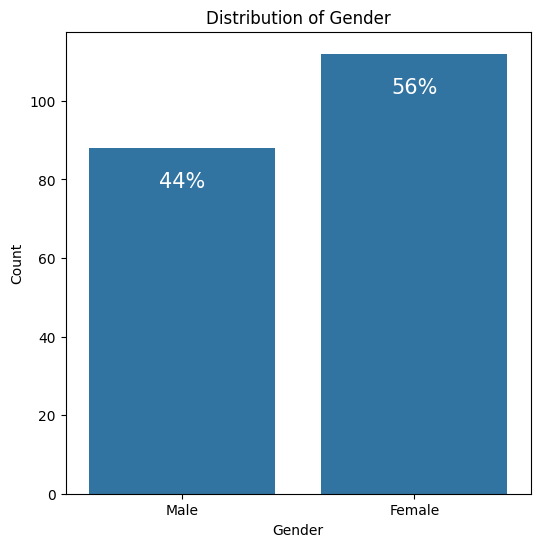

In [ ]:
# Calculate percentange of gender
gender_percent = pd.DataFrame()
gender_percent["Count"] = df.groupby("Gender")["CustomerID"].count()
gender_percent["Percent"] = gender_percent["Count"] / gender_percent["Count"].sum() * 100
gender_percent["Percent"] = gender_percent["Percent"].astype(int)
female = gender_percent["Percent"].iloc[0]
male = gender_percent["Percent"].iloc[1]

## Plotting this in a bar chart we can see that there are more females than males in the data.
plt.figure(figsize = (6, 6))
sns.countplot(data = df, x = "Gender")
plt.annotate(str(female)+"%", xy=(1, gender_percent["Count"].iloc[0]-10), color = 'white', size = 15, ha = 'center')
plt.annotate(str(male)+"%", xy=(0,gender_percent["Count"].iloc[1]-10), color = 'white', size = 15, ha = 'center')
plt.ylabel("Count")
plt.title("Distribution of Gender")
plt.show()

<Figure size 1500x600 with 0 Axes>

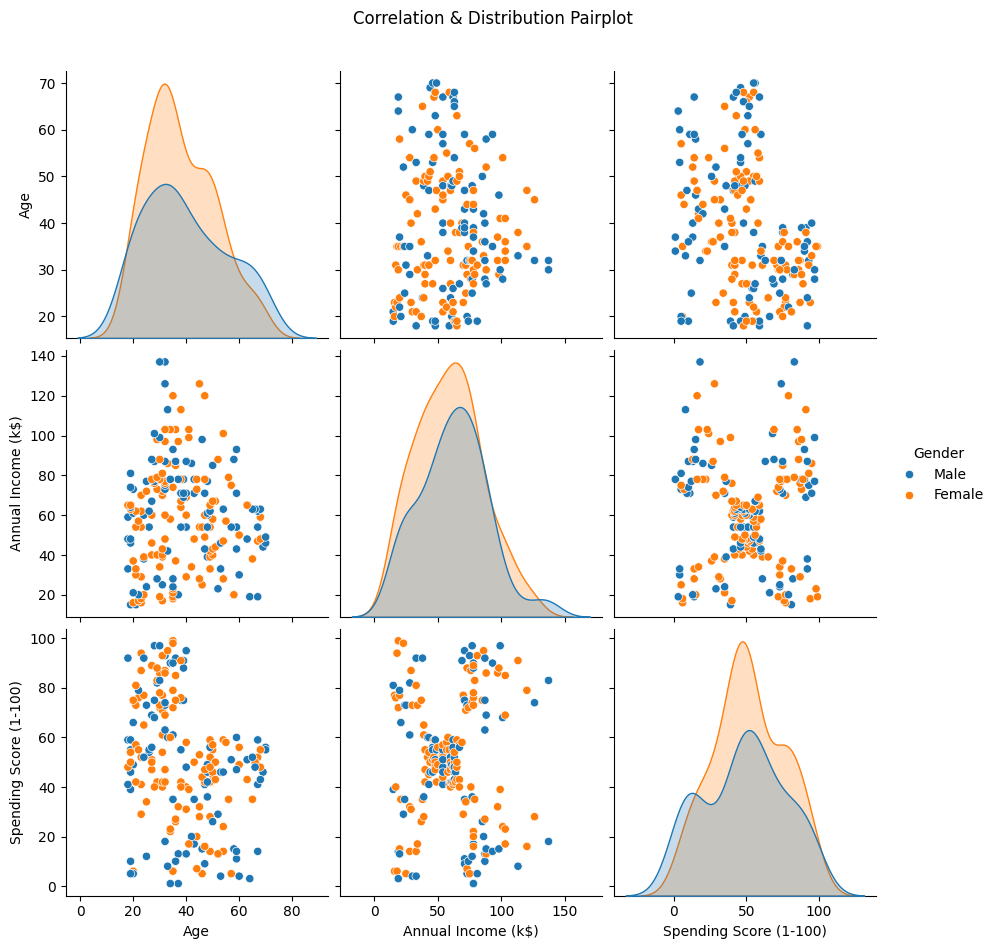

In [ ]:
## Now we visualise the correlation and distribution of the numeric variables using a pair plot.
## The data points are also split by gender by applying different colours to the plot.

plt.figure(figsize = (15, 6))
sns.pairplot(sub_df, hue = "Gender", height = 3)
plt.suptitle("Correlation & Distribution Pairplot", y=1.05)
plt.show()

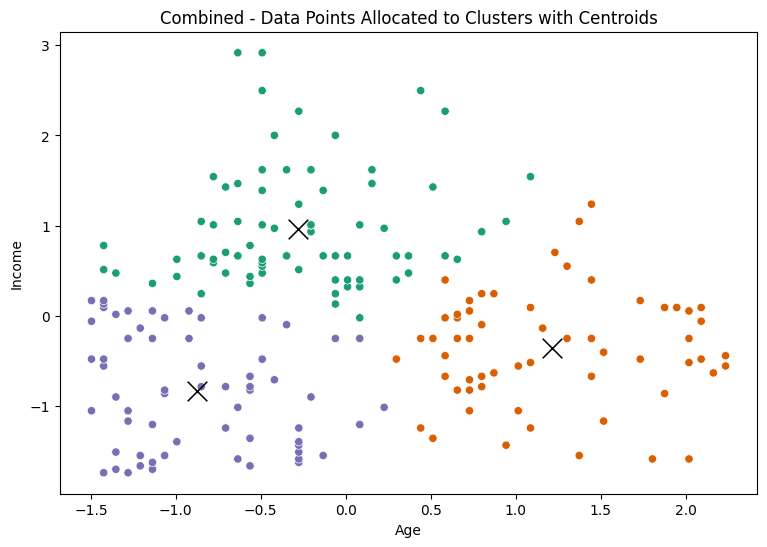

In [ ]:
# Scale the features (only age and annual income is selected)
scaler = StandardScaler()
features = df[["Age", "Annual Income (k$)"]]
std_features = scaler.fit_transform(features)
std_features_df = pd.DataFrame({"std_age": std_features[:, 0], "std_income": std_features[:, 1]})

# Append the gender column to the dataframe
std_df = pd.concat([std_features_df, df["Gender"]], axis = 1)

# Split the data into male and femail dataframes
male_std_df = std_df[std_df["Gender"] == "Male"][["std_age", "std_income"]]
female_std_df = std_df[std_df["Gender"] == "Female"][["std_age", "std_income"]]

# Apply k-means clustering to the full dataset
km = (KMeans(n_clusters = 3, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001, random_state= 19))
km.fit(std_features_df)
all_labels = km.labels_
all_centroids = km.cluster_centers_

plt.figure(figsize = (9,6))
sns.scatterplot(x = std_features_df.iloc[:, 0], y = std_features_df.iloc[:, -1], hue = all_labels, palette = "Dark2", legend = False)
sns.scatterplot(x = all_centroids[:, 0], y = all_centroids[:, 1], color = "black", marker = "x", s = 200)
plt.ylabel("Income")
plt.xlabel("Age")
plt.title("Combined - Data Points Allocated to Clusters with Centroids")
plt.show()

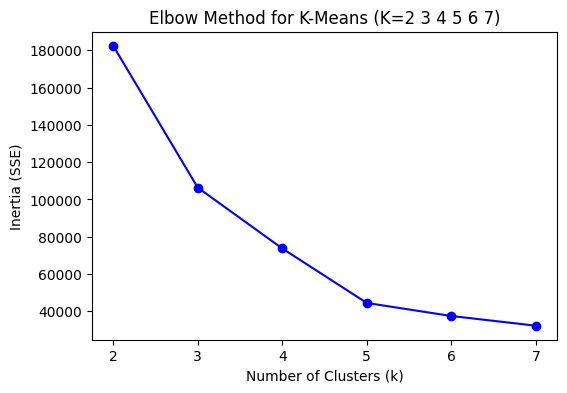

Chosen k = 3
Silhouette Score:     0.4676  (higher is better)
Davies-Bouldin Index: 0.7153  (lower is better)


In [ ]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

inertias = []
K_range = range(2, 8)
dbi_scores = []
sil_scores = []


for k in K_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertias, 'bo-')
plt.title("Elbow Method for K-Means (K=2 3 4 5 6 7)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.show()

# Optimal K, Optimal K is 3
optimal_k = 3
kmeans_opt = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans_opt.fit_predict(X)

# Silhouette Score and DBI
sil_score = silhouette_score(X, labels)
dbi_score = davies_bouldin_score(X, labels)

print(f"Chosen k = {optimal_k}")
print(f"Silhouette Score:     {sil_score:.4f}  (higher is better)")
print(f"Davies-Bouldin Index: {dbi_score:.4f}  (lower is better)")

## The closer the silhouette score is near 1, the better the separation. It goes from -1 to 1.
## Cluster separation is measured by DBI; the lower the number, the better.

## Therefore, better-defined clusters are indicated by a lower DBI and a higher Silhouette Score combined.